In [39]:
from sklearn import datasets

df_iris= datasets.load_iris()

In [40]:
df_iris.DESCR

'.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ============== ==== =

In [41]:
df_iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [42]:
import numpy as np
Y = df_iris.target
X= df_iris.data
X.shape

(150, 4)

In [43]:
from sklearn import model_selection
X_train , X_test, Y_train, Y_test = model_selection.train_test_split(X,Y)

In [44]:
import math as mt

In [45]:
#Node of Decision tree 
#Storing parameters like entropy, possible outputs, feature to split on
#also contain the refrence of children Nodes to traverse the whole tree
class graph_Node:
    def __init__(self, Y_set, local_decision, entropy, level, split_feature=None, split_point=None, feature_names=None, gainRatio=None):
        self.Y_set = Y_set
        self.local_decision = local_decision
        self.entropy = entropy
        self.level =level
        self.split_feature = split_feature
        self.split_point = split_point
        self.feature_names = feature_names
        self.gainRatio = gainRatio
        self.children = [None, None]
    def display(self):
        print('\nLevel:', self.level)
        for y in self.Y_set:
            print('count of', y, ':', self.Y_set[y])
        print('current entropy:', self.entropy)
        if self.children[0] ==None and self.children[1]==None:
            print('Reached leaf')
            print('Final decision:', self.local_decision)
            return
        print('Feature to split on:', self.feature_names[self.split_feature])
        print('Point to split on:', self.split_point)
        print('Gain Ratio:', self.gainRatio)
        self.children[0].display()
        self.children[1].display()
        

In [46]:
def Entropy_ofNode(Y_train): #function to find out entropy of given Node and returning different output that can be possible on this node
                             #along with most probable output
    Y_set = {}
    local_decision=Y_train[0]
    for y in Y_train:
        if y in Y_set:
            Y_set[y]+=1
        else:
            Y_set[y]=1
        if Y_set[y] > Y_set[local_decision]:
            local_decision = y
    
    entropy = 0
    for y in Y_set:
        p = (Y_set[y]/ Y_train.shape[0])
        entropy -= (p *mt.log10(p))
        
    return Y_set, local_decision, entropy

In [47]:
def sort_X(Feature):
    Feature = np.sort(Feature)
    uniq_x=[Feature[0]]
    
    #remove duplicate from array
    for i in Feature:
        if uniq_x[-1] != i:
            uniq_x.append(i)
    return uniq_x
    

In [48]:
def gain_Ratio(feature, X_train, Y_train, Entropy_old):
    
    #All feature are continues so, spliting data on the basis of particular feature 
    #A spliting point will be choosen that will split feature such that gain ratio will be maximum
    
    split_point=0
    Max_gain=0
    X_feature_sorted = sort_X(X_train[:, feature])
    for i in range(len(X_feature_sorted)-1):
        local_split=(X_feature_sorted[i]+X_feature_sorted[i+1])/2
        
        decision = (X_train[: , feature] >= local_split)
        #Dividing on data in two parts i.e. greater than and lesser than spliting point
        Y_train_greater = Y_train[decision]
        Y_train_lesser = Y_train[~ decision]
        
        #Calculating entropy for this split
        Greater= Entropy_ofNode( Y_train_greater)
        Lesser = Entropy_ofNode( Y_train_lesser)
        
        #Gain ratio calculations
        Greater_weight = Y_train_greater.shape[0]/Y_train.shape[0]
        Lesser_weight = Y_train_lesser.shape[0]/Y_train.shape[0]
        Entropy_new = Greater_weight*Greater[2] + Lesser_weight*Lesser[2]
        info_gain = Entropy_old - Entropy_new
        split_no= -Greater_weight*mt.log10(Greater_weight) -Lesser_weight*mt.log10(Lesser_weight)
        local_gain_ratio = info_gain /split_no
        
        if local_gain_ratio > Max_gain:
            Max_gain = local_gain_ratio
            split_point = local_split
            
    return Max_gain,split_point
            
        
        
        
        
        

In [49]:
def fit(X_train , Y_train , feature_Remaining, level):
    
    Y_set, local_decision, entropy = Entropy_ofNode(Y_train)
    
    if X_train.shape[1]==0 or len(Y_set)==1 or entropy<0.08:
        Node = graph_Node(Y_set,local_decision, entropy, level)
        return Node
        
    
    Max_gain = 0
    feature_max= 0
    split_point =0
    for feature in range(X_train.shape[1]):
        F_gain, sp= gain_Ratio(feature, X_train, Y_train, entropy)
        if F_gain > Max_gain:
            Max_gain =F_gain
            feature_max =feature
            split_point = sp
    
    #feature_max: Feature to split on to get maximum gain ratio
    
    
    #Spliting data in two parts: 
    #1)Data which has selected feature greater than split point
    #2)----------||------------------- lesser than split point
    decision = (X_train[: , feature_max] >= split_point)
    X_train_greater = X_train[decision]
    Y_train_greater = Y_train[decision]
    X_train_lesser = X_train[~ decision]
    Y_train_lesser = Y_train[~ decision]
    
    #recursivelly forming decision tree for two parts
    Greater_node=fit(X_train_greater, Y_train_greater, feature_Remaining , level+1)
    Lesser_node =fit(X_train_lesser, Y_train_lesser, feature_Remaining, level +1)
    
    #build graph node object of decision tree 
    Node = graph_Node(Y_set,local_decision, entropy, level, feature_max, split_point, feature_Remaining, Max_gain )
    Node.children[0]= Greater_node
    Node.children[1] = Lesser_node
    
    return Node
    
    
    
        

In [50]:
def predict(X_test, Node ):
    
    if X_test.shape[0]==0:
        return np.array([])
    if Node.children[0]==None and Node.children[1]==None:
        return np.array([Node.local_decision]*X_test.shape[0])
    
    #spliting testing data on the basis of feature given in Node of Decision Tree
    decision = X_test[:, Node.split_feature ] >= Node.split_point
    
    X_test_greater = X_test[decision]
    Y_predict_greater = predict(X_test_greater, Node.children[0])
    
    X_test_lesser = X_test[~ decision]
    Y_predict_lesser = predict( X_test_lesser, Node.children[1])
    
    #joining the both output arrays
    Y_predict = []
    i,j=0,0
    for b in decision:
        if b:
            Y_predict.append(Y_predict_greater[i])
            i+=1
        else:
            Y_predict.append(Y_predict_lesser[j])
            j+=1
    Y_pred = np.array(Y_predict)
    
    return Y_pred
    
            

In [51]:
decisionTree = fit(X_train, Y_train,df_iris.feature_names, 0)
decisionTree.display() #Depth first search printing of Decision tree graph
Y_predict = predict(X_test, decisionTree)



Level: 0
count of 1 : 41
count of 2 : 31
count of 0 : 40
current entropy: 0.4738720379604485
Feature to split on: petal length (cm)
Point to split on: 2.45
Gain Ratio: 0.9999999999999998

Level: 1
count of 1 : 41
count of 2 : 31
current entropy: 0.2968276265094406
Feature to split on: petal width (cm)
Point to split on: 1.75
Gain Ratio: 0.7000765646018327

Level: 2
count of 2 : 28
count of 1 : 1
current entropy: 0.06514196763750303
Reached leaf
Final decision: 2

Level: 2
count of 1 : 40
count of 2 : 3
current entropy: 0.10989256215452879
Feature to split on: petal length (cm)
Point to split on: 4.95
Gain Ratio: 0.2598057509649013

Level: 3
count of 1 : 2
count of 2 : 2
current entropy: 0.3010299956639812
Feature to split on: petal width (cm)
Point to split on: 1.55
Gain Ratio: 1.0

Level: 4
count of 1 : 2
current entropy: 0.0
Reached leaf
Final decision: 1

Level: 4
count of 2 : 2
current entropy: 0.0
Reached leaf
Final decision: 2

Level: 3
count of 1 : 38
count of 2 : 1
current ent

In [62]:
from sklearn.metrics import confusion_matrix,accuracy_score
print("confusion matrix:" )
print(confusion_matrix(Y_test,Y_predict))
print("accuracy score:",accuracy_score(Y_test,Y_predict))

confusion matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  1 18]]
accuracy score: 0.9736842105263158


#Visualization of decision boundries

In [53]:
def makegrid(x1, x2, h = 0.02):
    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x2.min() - 1, x2.max() + 1
    a = np.arange(x1_min,x1_max,h)
    b = np.arange(x2_min, x2_max, h)
    xx, yy = np.meshgrid(a, b)
    return xx, yy

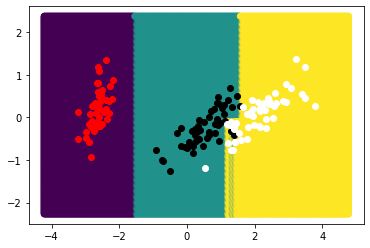

In [55]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2) #used PCA for reducing features to 2, so that we can plot it in 2-D
X_vis=pca.fit_transform(X)
Desc_tree=fit(X_vis, Y,df_iris.feature_names, 0)
xx, yy = makegrid(X_vis[:,0],X_vis[:,1])
X_ts_vis=np.c_[np.ravel(xx), np.ravel(yy)]
Y_pred_vis= predict(X_ts_vis,Desc_tree)
plt.scatter(X_ts_vis[:,0],X_ts_vis[:,1],c=Y_pred_vis)

cr =('red','black','white')
for i in range(3):
    plt.scatter(X_vis[Y==i,0],X_vis[Y==i,1],c=cr[i])

plt.show()